In [6]:
import os
import cv2
import random
import PIL.Image as Image
import tensorflow as tf
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
CSV_FILE = "./data/iris_thousands.csv"
BASE_DIR = "./data/CASIA-Iris-Thousand/"
NUM_CLASSES = 2000
IMAGE_WIDTH = 640    
IMAGE_HEIGHT = 480
IMAGE_CHANNELS = 1
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_SIZE_CHANNELS = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 24

In [3]:
def update_paths(csv_file, base_dir):
    iris_df = pd.read_csv(csv_file)
    
    corrected_paths = []
    missing_files = []

    for index, row in iris_df.iterrows():
        label = row['Label']  # Assuming 'Label' column contains the format "<subject_id>-<L/R>"
        image_filename = os.path.basename(row['ImagePath'])  # Extract the image file name
        subject_id, eye = label.split("-")  # Split into subject ID and eye (L/R)
        corrected_path = os.path.join(base_dir, subject_id, eye, image_filename)
        corrected_paths.append(corrected_path)

        # Check if the file exists
        if not os.path.exists(corrected_path):
            missing_files.append(corrected_path)

    # Add a new column "Images" to the dataset with the corrected paths
    iris_df["ImagesPath"] = corrected_paths

    # Check and print status of the file paths
    if not missing_files:
        print("All image paths are valid and exist in the dataset directory.")
    else:
        print(f"{len(missing_files)} missing image(s) found:")
        for file in missing_files:
            print(file)

    iris_df.to_csv(csv_file, index=False)
    print(f"Updated dataset saved to: {csv_file}")
    return iris_df

iris_data = update_paths(CSV_FILE, BASE_DIR)

All image paths are valid and exist in the dataset directory.
Updated dataset saved to: ./data/iris_thousands.csv


In [4]:
def check_class_distribution(dataset):
    class_counts = dataset['Label'].value_counts()
    print(class_counts)

    # Check for imbalances
    if class_counts.min() != class_counts.max():
        print("Class distribution is imbalanced.")
    else:
        print("Class distribution is balanced.")

check_class_distribution(iris_data)

437-R    10
700-L    10
149-R    10
241-L    10
241-R    10
         ..
452-L    10
452-R    10
151-L    10
151-R    10
715-L    10
Name: Label, Length: 2000, dtype: int64
Class distribution is balanced.


In [5]:
def check_image_dimensions(dataset, image_size):
    incorrect_dimensions = []
    for image_path in dataset["ImagesPath"]:
        img = Image.open(image_path)
        if img.size != image_size[:2]:  # Check width and height
            incorrect_dimensions.append((image_path, img.size))

    if incorrect_dimensions:
        print(f"{len(incorrect_dimensions)} image(s) with incorrect dimensions:")
        for file, size in incorrect_dimensions:
            print(f"{file} has size {size}")
    else:
        print("All images have correct dimensions.")

check_image_dimensions(iris_data, IMAGE_SIZE)


All images have correct dimensions.


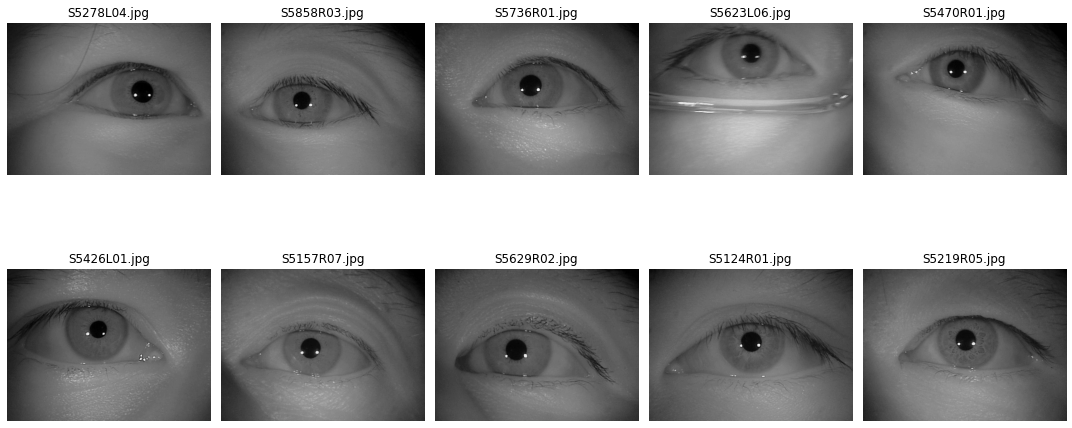

In [14]:
def visualize_images(dataset, num_images):
    sample_images = dataset.sample(num_images)["ImagesPath"].tolist()
    plt.figure(figsize=(15, 8))
    
    for i, image_path in enumerate(sample_images):
        img = Image.open(image_path)
        
        # Convert to grayscale if necessary
        if IMAGE_CHANNELS == 1:
            img = img.convert("L")
        
        # Add the image to the plot
        plt.subplot(2, (num_images + 1) // 2, i + 1)  # Dynamically create a grid
        plt.imshow(img, cmap="gray" if IMAGE_CHANNELS == 1 else None)
        plt.title(os.path.basename(image_path))
        plt.axis("off")
    
    # Display the images
    plt.tight_layout()
    plt.show()

# Visualize 10 random images
visualize_images(iris_data, num_images=10)